In [1]:
import findspark
SPARK_HOME = %env SPARK_HOME
findspark.init(SPARK_HOME)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.titlesize': 0, 'figure.figsize' : (4,3)})

import os
from os import listdir
from functools import reduce
import sys

from pyspark.sql.dataframe import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StructField, StringType, IntegerType , BooleanType, DoubleType
from pyspark.sql.window import Window

from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.appName('yahoo').getOrCreate()
sc = spark.sparkContext

In [4]:
import mlflow
from mlflow import log_metric, log_param, log_artifact, pyfunc
from mlflow.pyfunc import PythonModel

"""
mlflow server \
    --backend-store-uri sqlite:///mlflow.db \
    --default-artifact-root ./artifacts \
    --host 0.0.0.0
"""

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("yahoo")

### File imports and EDA

In [66]:
#Data set is composed of 100 individual files; split randomly into training/test folders at 70:30 ratio

mainpath = "yahoo_data/A2BENCHMARK/"
np.random.seed(111)
all_files = [f.name for f in os.scandir(mainpath) if f.is_file()]
test_files = np.random.choice(all_files, 30, replace=False)
[os.rename(mainpath + t, mainpath + "train/" + t) for t in  (set(all_files)-set(test_files))]
[os.rename(mainpath + t, mainpath + "test/" + t) for t in test_files]
len(test_files)

30

In [5]:
mainpath = "yahoo_data/A2BENCHMARK/"
df0 = spark.read.options(header='true', inferschema='true').csv(mainpath+"/train/synthetic_1.csv")
df0.printSchema()
df0.show(5,False)

root
 |-- timestamp: integer (nullable = true)
 |-- value: double (nullable = true)
 |-- is_anomaly: integer (nullable = true)

+----------+----------------+----------+
|timestamp |value           |is_anomaly|
+----------+----------------+----------+
|1416726000|13.8940312022431|0         |
|1416729600|33.5782735451433|0         |
|1416733200|88.9337461757894|0         |
|1416736800|125.38942370322 |0         |
|1416740400|152.961999637907|0         |
+----------+----------------+----------+
only showing top 5 rows



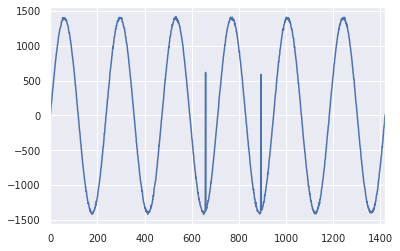

In [6]:
df0.toPandas().value.plot()

### Feature Engineering

In [7]:
train_dfs = [spark.read.options(header='true', inferschema='true').csv(mainpath + f"train/{csv}") for csv in os.listdir(mainpath + "train/")]
test_dfs = [spark.read.options(header='true', inferschema='true').csv(mainpath + f"test/{csv}") for csv in os.listdir(mainpath + "test/")]

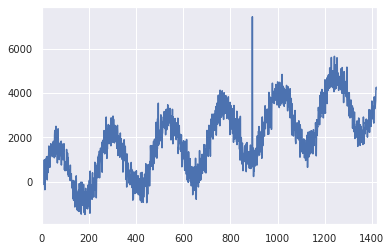

In [8]:
train_dfs[-1].toPandas().value.plot()

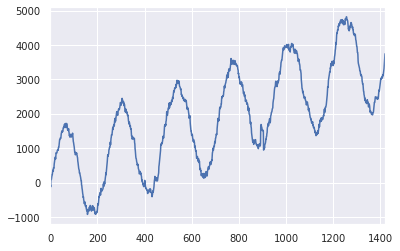

In [9]:
windowSpec = Window().orderBy('timestamp').rowsBetween(-11,0)
train_dfs[-1].withColumn("rolling_mean",F.mean("value").over(windowSpec)).toPandas().rolling_mean.plot()

In [10]:
def prepare_df(df: DataFrame) -> DataFrame:
    ts_window = Window.partitionBy().orderBy("timestamp")
    outdf = df.withColumn("value_lag1", F.lag(F.col("value")).over(ts_window))
    outdf = (outdf.withColumn("value_diff1", F.when(F.isnull(outdf.value - outdf.value_lag1), 0)
                                              .otherwise(outdf.value - outdf.value_lag1)))
    
    #2nd difference
    outdf = outdf.withColumn("value_diff1_lag1", F.lag(F.col("value_diff1")).over(ts_window))
    outdf = (outdf.withColumn("value_diff2", F.when(F.isnull(outdf.value_diff1 - outdf.value_diff1_lag1), 0)
                                              .otherwise(outdf.value_diff1 - outdf.value_diff1_lag1)))
    
    #outdf = outdf.na.fill(0)
    # Use backfill instead of na
    bf_window = Window.orderBy('timestamp').rowsBetween(0, sys.maxsize)
    outdf = (outdf.withColumn('value_lag1', F.first(outdf['value_lag1'], ignorenulls=True).over(bf_window))
                  .withColumn('value_diff1_lag1', F.first(outdf['value_diff1_lag1'], ignorenulls=True).over(bf_window)))
                             
    quantiles = outdf.approxQuantile("value_diff1", [0.25,0.75],0.05)
    outdf = (outdf.join(outdf.agg(F.stddev(F.col("value_diff1")).alias("std")))
                  .withColumn("q1", F.lit(quantiles[0]))
                  .withColumn("q3", F.lit(quantiles[1])))
                
    quantiles = outdf.approxQuantile("value_diff2", [0.25,0.75],0.05)
    outdf = (outdf.join(outdf.agg(F.stddev(F.col("value_diff2")).alias("std2")))
              .withColumn("q1_2", F.lit(quantiles[0]))
              .withColumn("q3_2", F.lit(quantiles[1])))
    
    

    return outdf

In [11]:
prepare_df(df0).limit(3).toPandas()

,timestamp,value,is_anomaly,value_lag1,value_diff1,value_diff1_lag1,value_diff2,std,q1,q3,std2,q1_2,q3_2
0,1416726000,13.894031,0,13.894031,0.000000,0.000000,0.000000,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152
1,1416729600,33.578274,0,13.894031,19.684242,0.000000,19.684242,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152
2,1416733200,88.933746,0,33.578274,55.355473,19.684242,35.671230,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152


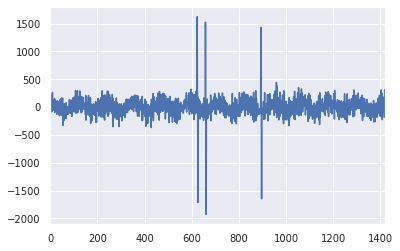

In [12]:
prepare_df(train_dfs[45]).toPandas().value_diff1.plot()

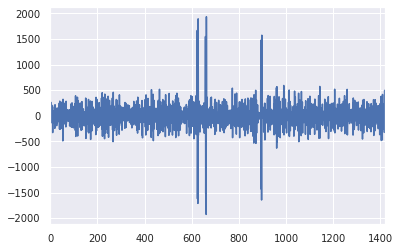

In [13]:
prepare_df(train_dfs[45]).toPandas().value_diff2.plot()

In [14]:
prepared_train_dfs = list(map(prepare_df, train_dfs))
prepared_test_dfs = list(map(prepare_df, test_dfs))
train_df = reduce(DataFrame.unionAll, prepared_train_dfs)
test_df = reduce(DataFrame.unionAll, prepared_test_dfs)

### Model Definition and udf wrapping

In [26]:
def predict_from_quants(value_diff1: float, q1: float, q3: float, value_diff2: float, q1_2: float, q3_2: float) -> float:
    threshold, threshold2 = (3.4, 4.2)
    Q1, Q1_2 = (float(q1), float(q1_2))
    Q3, Q3_2 = (float(q3), float(q3_2))
    IQR, IQR_2 = (Q3 - Q1, Q3_2 - Q1_2)
    if (float(value_diff1) < (Q1 - IQR*threshold) or float(value_diff1) > Q3 + IQR*threshold or
        float(value_diff2) < (Q1_2 - IQR_2*threshold2) or float(value_diff2) > Q3_2 + IQR_2*threshold2):
        return 1.0
    else:
        return 0.0

class UDFWrapper(PythonModel):
    def __init__(self, estimator=None):
        return None
    def predict(self, context, X):
        return np.array(predict_from_quants(*X.to_numpy().T))

In [27]:
from typing import Callable

def apply_prediction(df: DataFrame, prediction_function: Callable, columns):
    return df.withColumn("prediction", F.udf(prediction_function, DoubleType())(*columns))

# Load model from registry
def apply_prediction_saved(df: DataFrame, model_path: str = "models:/yahoo_model_quant/Staging", columns = ["value_diff1", "q1", "q3"]):
    prediction_udf = mlflow.pyfunc.spark_udf(spark, model_path)
    return df.withColumn('prediction', prediction_udf(*columns))

In [28]:
apply_prediction(prepare_df(df0), predict_from_quants, ["value_diff1", "q1", "q3", "value_diff2", "q1_2", "q3_2"]).limit(3).toPandas()

,timestamp,value,is_anomaly,value_lag1,value_diff1,value_diff1_lag1,value_diff2,std,q1,q3,std2,q1_2,q3_2,prediction
0,1416726000,13.894031,0,13.894031,0.000000,0.000000,0.000000,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,0.0
1,1416729600,33.578274,0,13.894031,19.684242,0.000000,19.684242,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,0.0
2,1416733200,88.933746,0,33.578274,55.355473,19.684242,35.671230,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,0.0


In [25]:
apply_prediction_saved(prepare_df(df0)).limit(3).toPandas()

,timestamp,value,is_anomaly,value_lag1,value_diff1,value_diff1_lag1,value_diff2,std,q1,q3,std2,q1_2,q3_2,prediction
0,1416726000,13.894031,0,13.894031,0.000000,0.000000,0.000000,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,0.0
1,1416729600,33.578274,0,13.894031,19.684242,0.000000,19.684242,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,0.0
2,1416733200,88.933746,0,33.578274,55.355473,19.684242,35.671230,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,0.0


In [29]:
evaluator = BinaryClassificationEvaluator().setRawPredictionCol("prediction").setLabelCol("is_anomaly")
result = evaluator.evaluate(apply_prediction(test_df, predict_from_quants, ["value_diff1", "q1", "q3", "value_diff2", "q1_2", "q3_2"]))
print(result)
log_artifact("yahoo.ipynb", "jup_logs")
log_param("type", "quantile_comb_diff")
log_param("na_fill_type", "backfill")
log_param("threshold1", str(3.4))
log_param("threshold2", str(4.2))
log_metric("AreaUnderROC", result)

"""
Currently, loading the model after saving it ends the run. In order to associate the current model with its params, I'm logging it again.
The consequences of this are that useful model versions iterate by 2, and every other experiment run is empty
"""
mlflow.pyfunc.log_model(
            python_model=UDFWrapper(),
            registered_model_name="yahoo_model_quant_comb_diff",
            artifact_path="yahoo_models"
        )
mlflow.end_run()

0.8344286635764028


Registered model 'yahoo_model_quant_comb_diff' already exists. Creating a new version of this model...
Created version '15' of model 'yahoo_model_quant_comb_diff'.
